# JAX phenotype analyses

This notebook explores potential nonlinearities between JAX phenotypes. Phenotypic data were collected from a variety of publications and were selected to attempt to span the full range of phenotypic space. The compiled dataset is available via [S3](https://arcadia-public-genetic-mapping-datasets.s3.us-west-1.amazonaws.com/jax_phenotypes/). 
***

## Load and compile phenotypes

Load packages

In [2]:
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(gplots))
suppressPackageStartupMessages(library(missMDA))
suppressPackageStartupMessages(library(FactoMineR))
suppressPackageStartupMessages(library(RNOmni))
suppressPackageStartupMessages(library(umap))
suppressPackageStartupMessages(library(energy))
suppressPackageStartupMessages(library(mgcv))
suppressPackageStartupMessages(library(lmtest))
suppressPackageStartupMessages(library(scales))

Set working directory to be at top of directory structure

In [15]:
setwd('../../')

Make temporary folder to download JAX phenotype data into

In [16]:
system('mkdir jax_phenotypes')

Download JAX phenotype data from S3

In [17]:
system('aws s3 cp s3://arcadia-public-genetic-mapping-datasets/jax_phenotypes/ jax_phenotypes/ --recursive')

Load data

In [18]:
dat = read.csv('jax_phenotypes/strainmeans.csv')

Extract all strain names

In [7]:
strains = unique(dat$strainid)

Split strain data on phenotype

In [8]:
x = split(dat, dat$varname)

Match data order to overall strain list

In [9]:
for(i in 1:length(x)){
  x[[i]] = x[[i]][match(strains, x[[i]]$strainid),]
}

Combine data back together

In [10]:
phenos = as.data.frame(do.call(cbind, lapply(x, function(y) y$zscore)))
rownames(phenos) = strains

Filter on completeness

In [11]:
#Filter strains
phenos = phenos[apply(phenos, 1, function(x) sum(!is.na(x)))>100,]

#Filter phenotypes
phenos = phenos[,apply(phenos, 2, function(x) sum(!is.na(x)))>100]

#Filter strains
phenos = phenos[apply(phenos, 1, function(x) sum(!is.na(x)))>100,]

Save

In [ ]:
#write.csv(phenos, '02_output/all_jax_phenotypes.csv')

Remove temporary phenotype directory

In [19]:
system('rm -r jax_phenotypes')

## Explore data using dimensionality reduction

Read in data

In [20]:
phenos = read.csv('02_output/all_jax_phenotypes.csv')

Impute missing measurements (using column mean)

In [21]:
for(i in 1:ncol(phenos)){
  x = which(is.na(phenos[,i]))
  phenos[x,i] = mean(phenos[,i], na.rm = TRUE)
}

Normalize phenotypes using rank normalization

In [22]:
phenos_s = as.data.frame(apply(phenos, 2, function(x) RankNorm(x)))

Correlate phenotypes

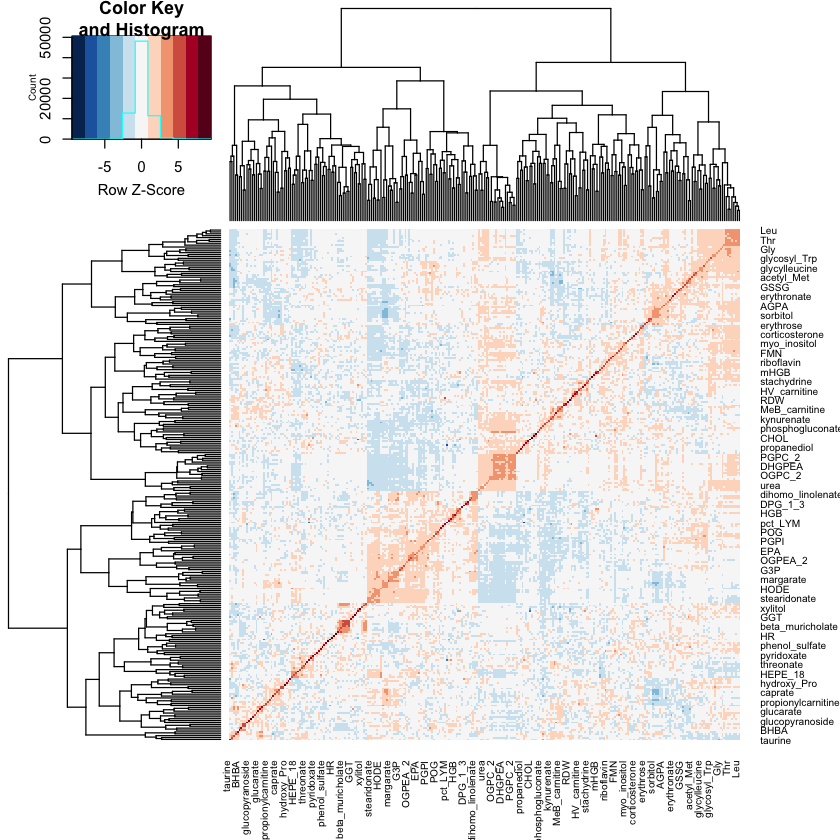

In [23]:
corr = cor(data.matrix(phenos_s), use = 'complete.obs')
heatmap.2(corr,
          col=rev(brewer.pal(11,"RdBu")),
          scale="row", 
          trace="none")

PCA

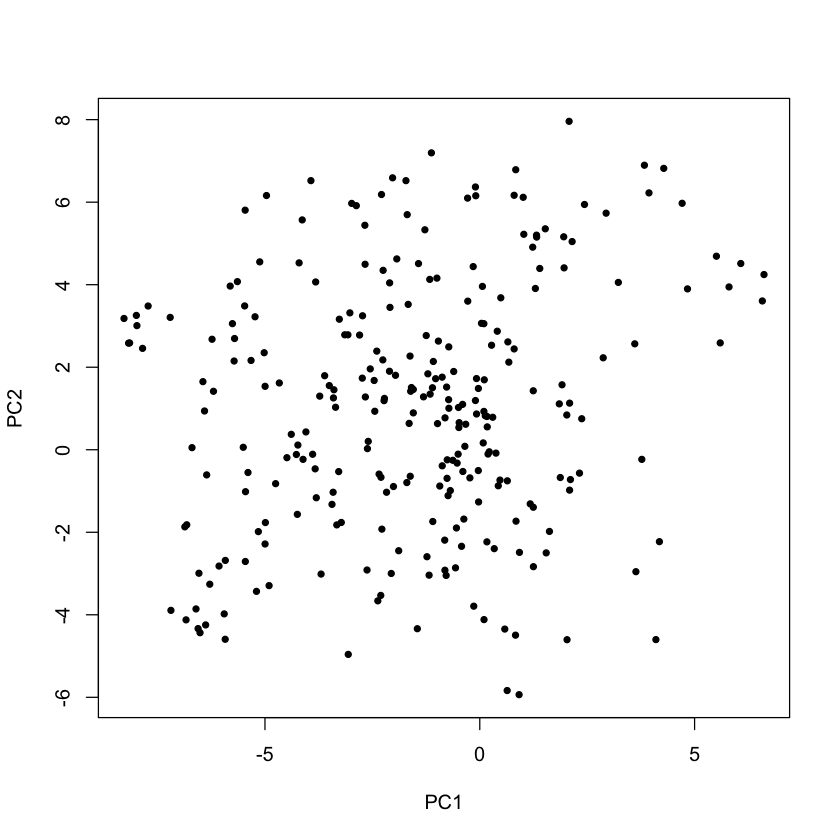

In [24]:
pca = prcomp(t(phenos_s), scale. = TRUE, center = FALSE)
plot(pca$x[,1:2], pch = 20)

UMAP

[2022-09-27 10:29:51]  starting umap

[2022-09-27 10:29:51]  creating graph of nearest neighbors

[2022-09-27 10:29:51]  creating initial embedding

[2022-09-27 10:29:51]  optimizing embedding

[2022-09-27 10:29:51]  done



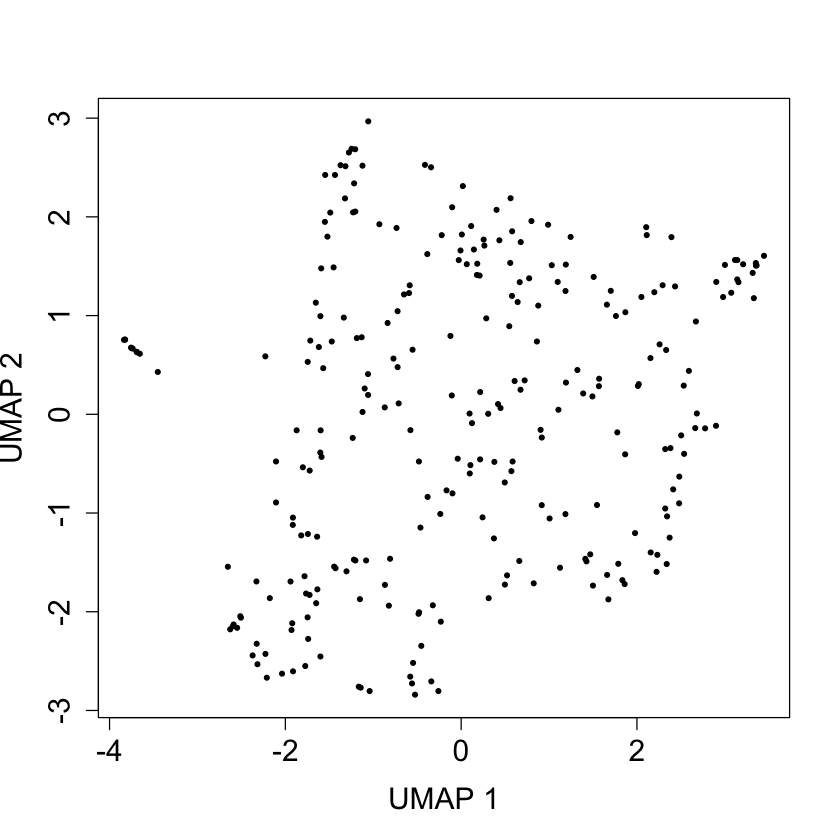

In [25]:
u = umap(t(phenos_s), verbose = TRUE)

plot(u$layout, 
     pch = 20, 
     cex = 0.8,
     xlab = 'UMAP 1',
     ylab = 'UMAP 2',
     cex.axis = 1.5,
     cex.lab = 1.5)

## Testing linear vs. non-linear components via models

Get all possible phenotype combinations

In [26]:
all = expand.grid(1:ncol(phenos_s), 1:ncol(phenos_s))

Convert data to numeric matrix

In [27]:
z = data.matrix(phenos_s)

Calculate linear and non-linear models for all traits (note: takes a long time to run)

In [29]:
#Initiate progress bar
pb <- txtProgressBar(min = 0,      
                     max = nrow(all), 
                     style = 3,    
                     width = 50,
                     char = ".")

#Loop through and run
res = list()
for(i in 1:nrow(all)){
  
  #Update progress bar
  setTxtProgressBar(pb, i)
  
  mod1 = lm(z[,all[i,1]]~z[,all[i,2]])
  mod2 = gam(z[,all[i,1]]~s(z[,all[i,2]], k = length(unique(z[,all[i,2]]))-1))
  
  out = lrtest(mod1, mod2)
  a = AIC(mod1, mod2)
  
  l = list(out, a)
  names(l) = c('lrtest', 'AIC')
  
  res[[paste(colnames(phenos_s)[all[i,1]],
             colnames(phenos_s)[all[i,2]], 
             sep = '_')]] = l
}

  |..................................................| 100%

Save

In [30]:
saveRDS(res, '02_output/jax_linear_nonlinear_models.RDS')

Compare with AIC

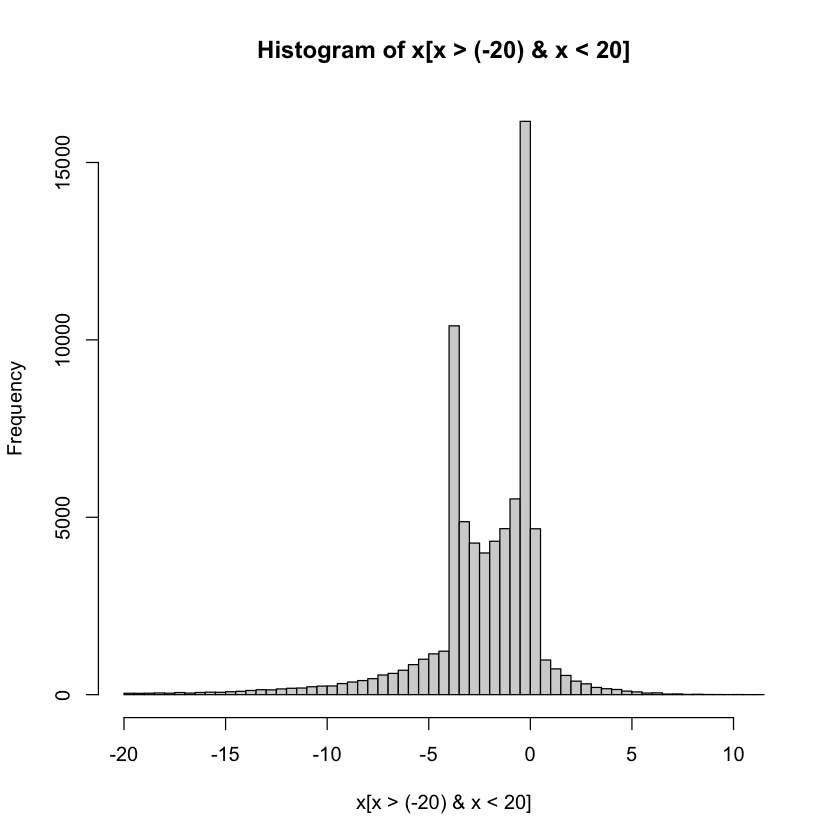

In [31]:
x = unlist(lapply(res, function(x) x$AIC[2,2]-x$AIC[1,2]))
hist(x[x>(-20)&x<20], breaks = 100)

Compare with likelihood

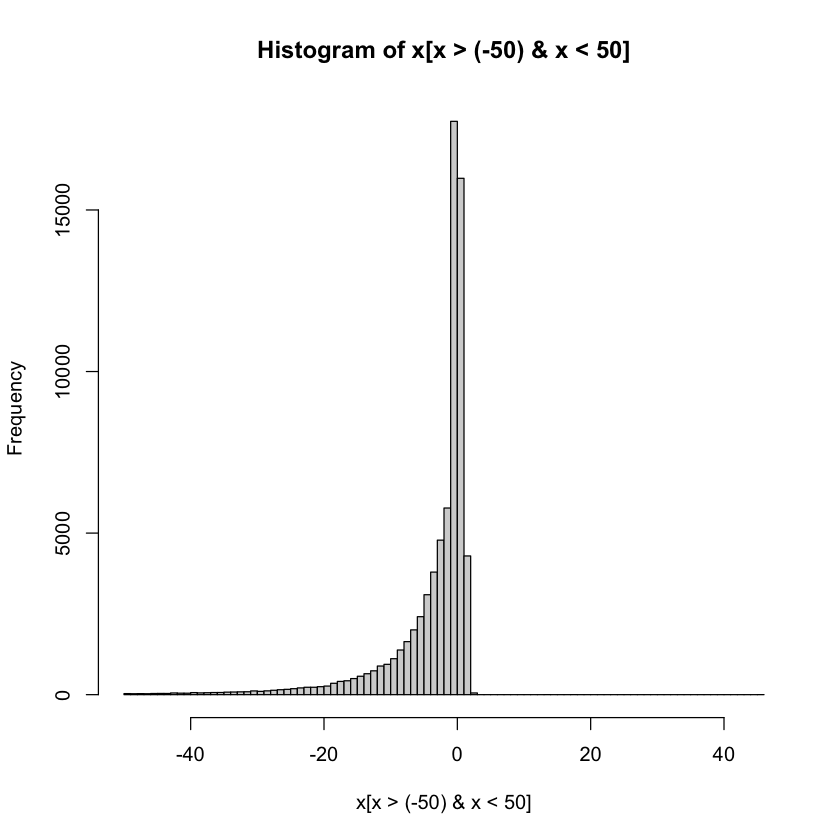

In [32]:
x = unlist(lapply(res, function(x) x$lrtest$LogLik[1]-x$lrtest$LogLik[2]))
hist(x[x>(-50)&x<50], breaks = 100)

Calculate breakdown of linear vs. nonlinear

In [33]:
x = unlist(lapply(res, function(x) x$lrtest$LogLik[1]-x$lrtest$LogLik[2]))
linear = sum(x>0)/length(x)
nonlinear = sum(x<0)/length(x)
print(c(linear, nonlinear))

[1] 0.2804428 0.7195572


Barplot

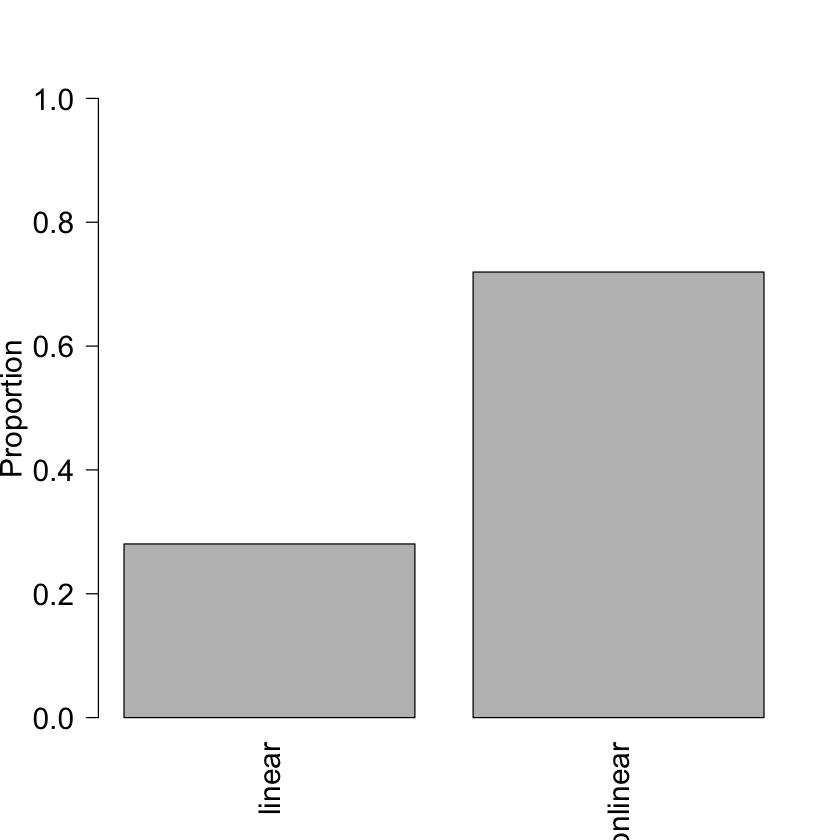

In [34]:
barplot(c(linear, nonlinear),
       ylab = 'Proportion',
       ylim = c(0,1),
       cex.axis = 1.5, cex.lab = 1.5, cex.names = 1.5,
       names = c('linear', 'nonlinear'),
       las = 2)